# 02 Limiting Photon Counts 

By looking at experimental fits, it is apparent that having too few or too many photons leads to bad fits. In the case of too few counts, there is too much background noise to identify peaks. Fits with too few or too many photons are excluded from the data in subsequent notebooks. 

In [1]:
import h5py
import pyxrfmaps as px 
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
element_csv_filename = "../reference/xrf_library.csv"
element_henke_filename = "../reference/henke.xdr"
input_filename = "../../2die_2012_2017.hdf5"

In [3]:
# Initial set up for XRF Maps
px.load_element_info(element_henke_filename, element_csv_filename)
trans = px.io.file.get_FILE_TAGS_TRANSLATION()
fit_rout = px.fitting.routines.nnls()

## Plotting the Fits

Plots show the poor quality of fits with low photon counts. This cell can be stopped early to prevent a long time spent plotting.

In [4]:
MIN_PHOTON_COUNTS_UPPER = 3_000
MIN_PHOTON_COUNTS_LOWER = 2_000

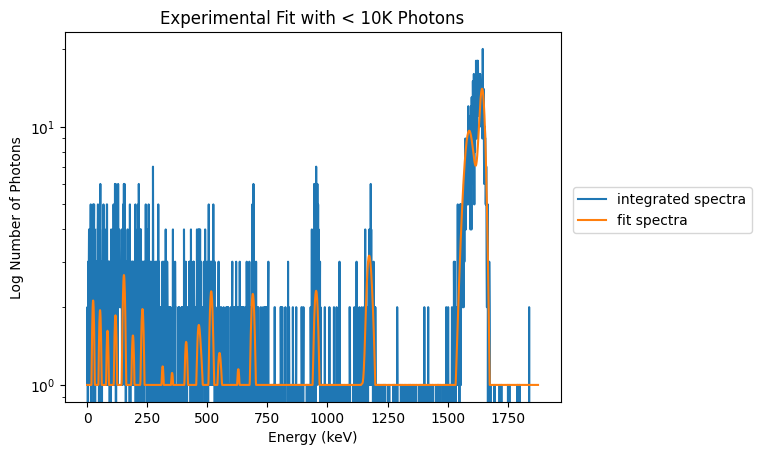

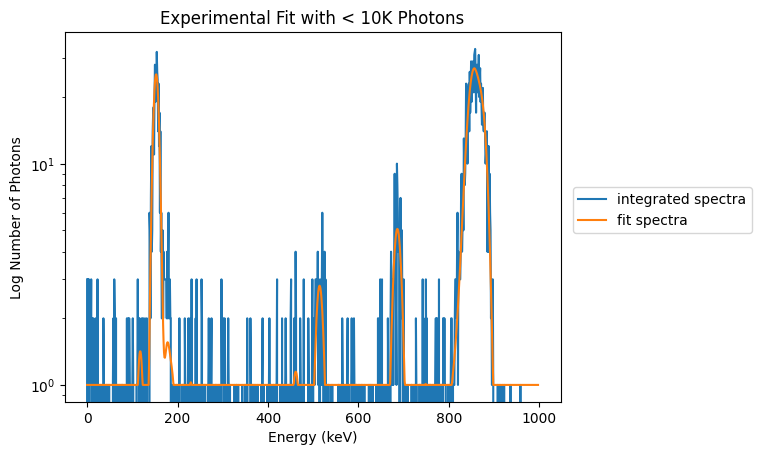

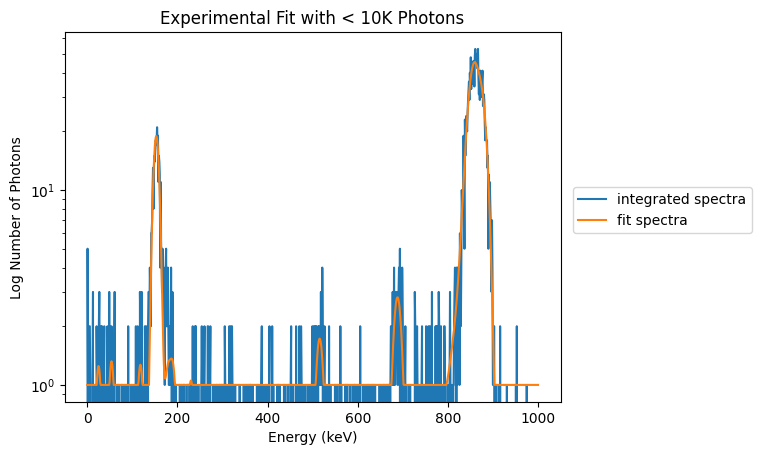

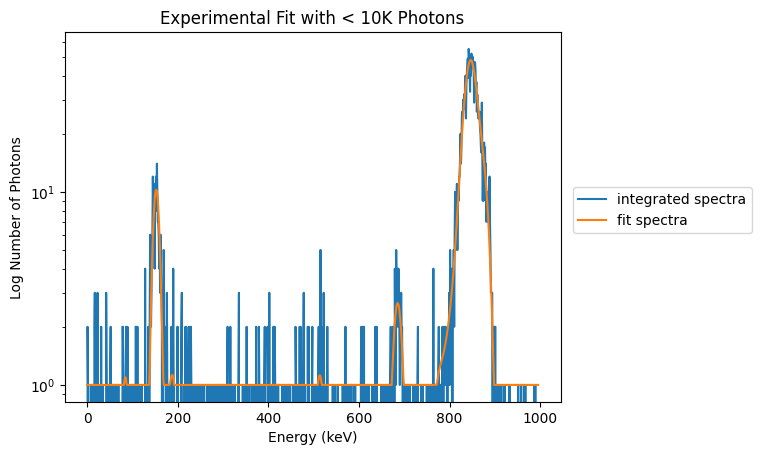

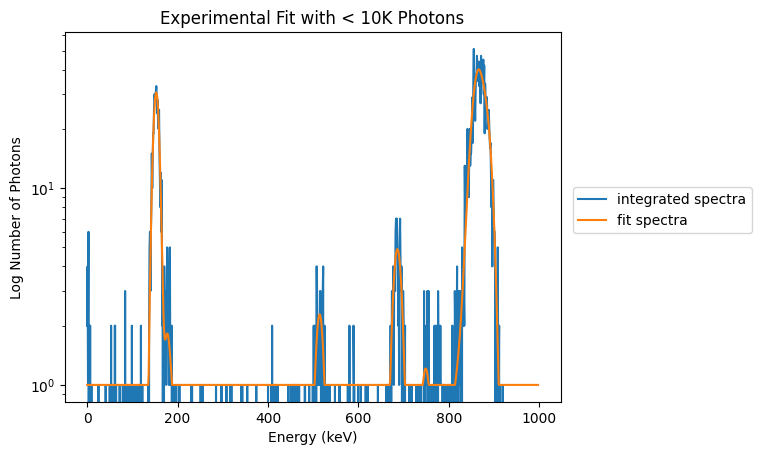

In [7]:
with h5py.File(input_filename, 'r') as infile:
    n_plots = 0
    for name, h5obj in infile.items():
        # Load dataset
        int_specs = h5obj['int_spectra']
        for spectra in int_specs:
            no_negatives = True
            for photon_count in spectra:
                if photon_count < 0:
                    no_negatives = False
            if no_negatives and n_plots < 5:
                photon_count_sum = sum(spectra)
                if photon_count_sum < MIN_PHOTON_COUNTS_UPPER and photon_count_sum > MIN_PHOTON_COUNTS_LOWER:
                    # Use Gaussian Model
                    model = px.fitting.models.GaussModel()
                    po = px.ParamsOverride()
                    
                    el = h5obj['elements'][()]
                    el = el.decode()        
                    el_list = [i.strip() for i in el.split(',')]
                    el_list += ['COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE']
   
                    po.fill_elements_from_dict(el_list, 'Si')
                    param_names = h5obj['fit_param_names'][...]
                    param_values = h5obj['fit_param_values'][...]
                    for name, value in zip(param_names, param_values):
                        name = name.decode()
                        if name in trans:
                            name = trans[name]
                        po.fit_params.add_parameter(px.Fit_Param(name, value))
                    model.update_fit_params_values(po.fit_params)
            
                    energy_range = px.get_energy_range(spectra.size, po.fit_params)
                    fit_rout.initialize(model, po.elements_to_fit, energy_range)

                    # Get Fit Spectra 
                    fit_spec = fit_rout.fit_spectra(model, spectra, po.elements_to_fit)
                    max_val = np.amax(fit_spec)
                    fit_spec = np.clip(fit_spec, 1, max_val)
                    # Resize int_spec to match fit_spec
                    resize_spectra = spectra[energy_range.min:energy_range.max+1]
                    n_plots += 1
                    i_ax = np.linspace(0, resize_spectra.size-1, resize_spectra.size)
                    f_ax = np.linspace(0, fit_spec.size-1, fit_spec.size)
                    fig, axs = plt.subplots()
                    axs.plot(i_ax, resize_spectra, label="integrated spectra")
                    axs.set_yscale('log')
                    axs.set_ylabel('Log Number of Photons')
                    axs.set_xlabel('Energy (keV)')
                    axs.set_title("Experimental Fit with < 10K Photons")
                    axs.plot(f_ax, fit_spec, label="fit spectra")
                    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.6))
                    plt.show()

In [8]:
MAX_PHOTON_COUNTS = 100_000_000

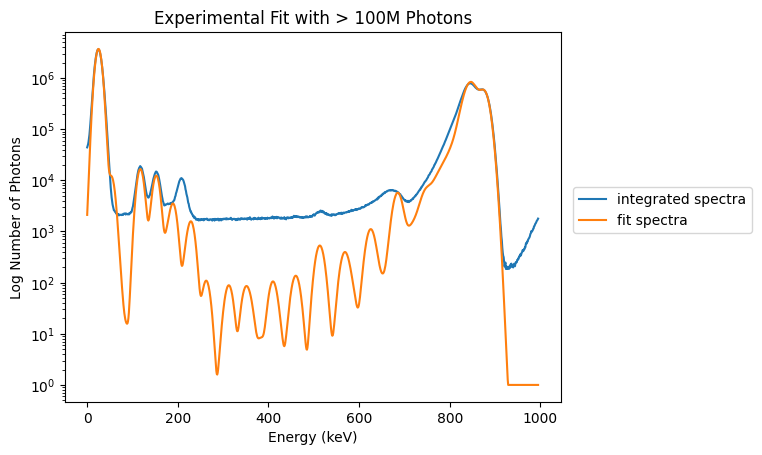

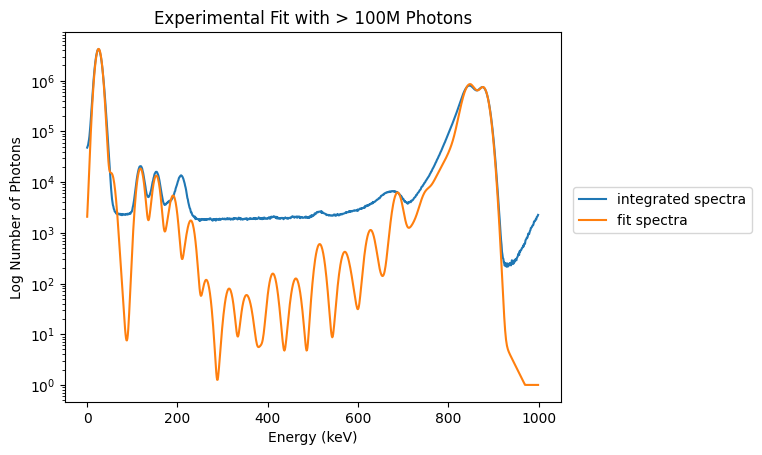

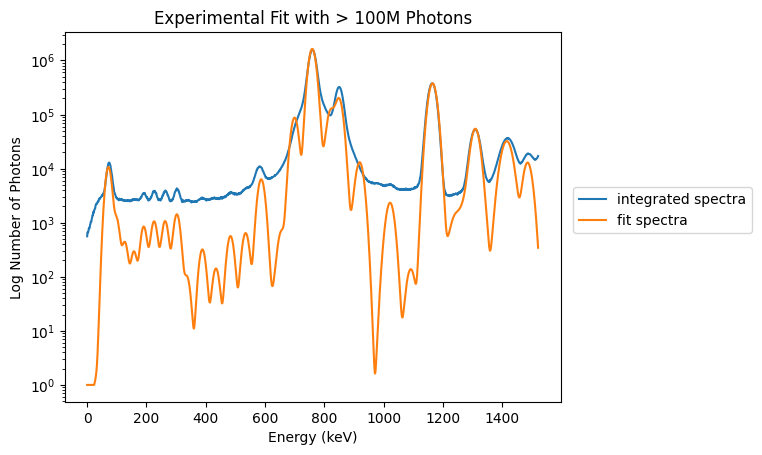

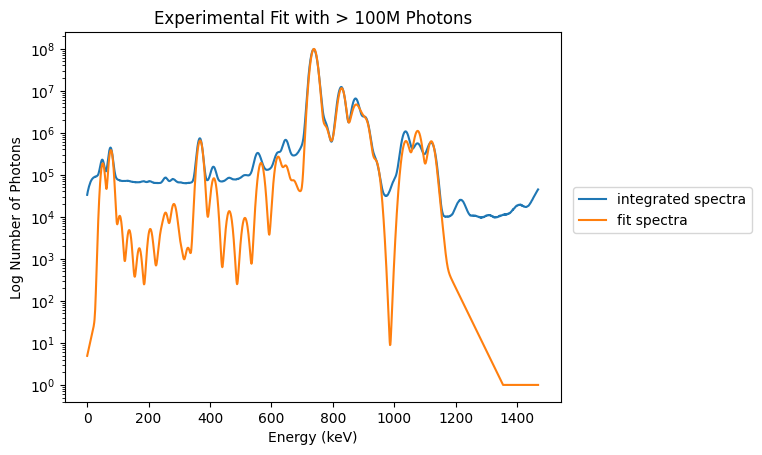

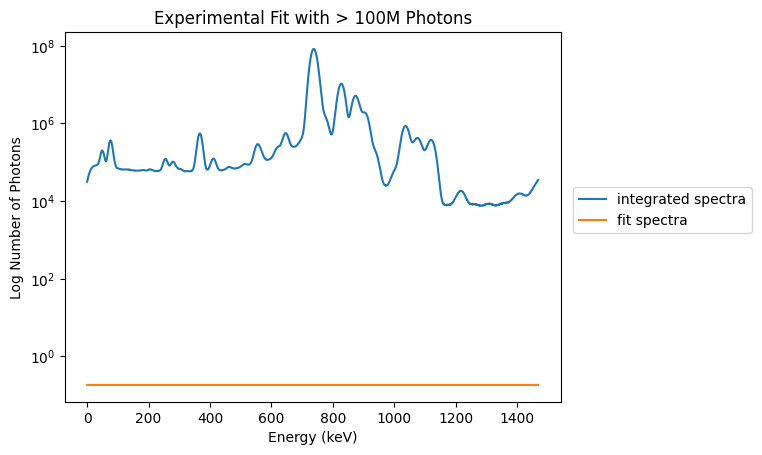

In [9]:
with h5py.File(input_filename, 'r') as infile:
    n_plots = 0
    for name, h5obj in infile.items():
        # Load dataset
        int_specs = h5obj['int_spectra']
        for spectra in int_specs:
            no_negatives = True
            for photon_count in spectra:
                if photon_count < 0:
                    no_negatives = False
            if no_negatives and n_plots < 5:
                photon_count_sum = sum(spectra)
                if photon_count_sum > MAX_PHOTON_COUNTS:
                    # Use Gaussian Model
                    model = px.fitting.models.GaussModel()
                    po = px.ParamsOverride()
                    
                    el = h5obj['elements'][()]
                    el = el.decode()        
                    el_list = [i.strip() for i in el.split(',')]
                    el_list += ['COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE']
   
                    po.fill_elements_from_dict(el_list, 'Si')
                    param_names = h5obj['fit_param_names'][...]
                    param_values = h5obj['fit_param_values'][...]
                    for name, value in zip(param_names, param_values):
                        name = name.decode()
                        if name in trans:
                            name = trans[name]
                        po.fit_params.add_parameter(px.Fit_Param(name, value))
                    model.update_fit_params_values(po.fit_params)
            
                    energy_range = px.get_energy_range(spectra.size, po.fit_params)
                    fit_rout.initialize(model, po.elements_to_fit, energy_range)

                    # Get Fit Spectra 
                    fit_spec = fit_rout.fit_spectra(model, spectra, po.elements_to_fit)
                    max_val = np.amax(fit_spec)
                    fit_spec = np.clip(fit_spec, 1, max_val)
                    # Resize int_spec to match fit_spec
                    resize_spectra = spectra[energy_range.min:energy_range.max+1]
                    n_plots += 1
                    i_ax = np.linspace(0, resize_spectra.size-1, resize_spectra.size)
                    f_ax = np.linspace(0, fit_spec.size-1, fit_spec.size)
                    fig, axs = plt.subplots()
                    axs.plot(i_ax, resize_spectra, label="integrated spectra")
                    axs.set_yscale('log')
                    axs.set_ylabel('Log Number of Photons')
                    axs.set_xlabel('Energy (keV)')
                    axs.set_title("Experimental Fit with > 100M Photons")
                    axs.plot(f_ax, fit_spec, label="fit spectra")
                    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.6))
                    plt.show()

## Setting the Limits

By adjusting the range of counts then inspecting a sampling of plots, 10K to 100M was chosen as a reasonable limit. 

In [26]:
MIN_PHOTON_COUNTS = 10_000
MAX_PHOTON_COUNTS = 100_000_000

## Filtering the Dataset

Data is filtered to remove experiments with low and high photon counts and saved to csv files. 
It is important to maintain the order the rows are written as the spectra in each row are related to the fitting parameters and elements of the same row.

In [30]:
filename = './training_data/01_int_spectra.csv'
with open(filename) as f:
    int_spectra = f.readlines()
    print(len(int_spectra))
filename = './training_data/01_resize_spectra.csv'
with open(filename) as f:
    resize_spectra = f.readlines()
    print(len(resize_spectra))
filename = './training_data/01_fit_spectra.csv'
with open(filename) as f:
    fit_spectra = f.readlines()
    print(len(fit_spectra))
filename = './training_data/01_elements.csv'
with open(filename) as f:
    elements = f.readlines()
    print(len(elements))
filename = './training_data/01_fit_params_standard.csv'
with open(filename) as f:
    fit_params = f.readlines()
    print(len(fit_params))
# Sanity check that the line counts match except for elements and fit params which should have an extra header line

105002
105002
105002
105003
105003


In [31]:
with open('./training_data/02_int_spectra.csv', 'w') as f_int:
    with open('./training_data/02_resize_spectra.csv', 'w') as f_resize:
        with open('./training_data/02_fit_spectra.csv', 'w') as f_fit:
            with open('./training_data/02_elements.csv', 'w') as f_elem:
                with open('./training_data/02_fit_params_standard.csv', 'w') as f_param:
                    # write headers
                    f_elem.write(elements[0])
                    f_param.write(fit_params[0])
                    for i in range(len(int_spectra)):
                        ct = 0
                        s = int_spectra[i].strip().split(',')
                        for j in range(len(s)):
                            ct += float(s[j])
                        if ct > MIN_PHOTON_COUNTS and ct < MAX_PHOTON_COUNTS:
                            f_int.write(int_spectra[i])                            
                            f_resize.write(resize_spectra[i])
                            f_fit.write(fit_spectra[i])
                            f_elem.write(elements[i + 1])
                            f_param.write(fit_params[i + 1])